In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
ls

data_fold0/  spine_detection/  state.db  yolo11n.pt  yolo_scs.yaml


In [3]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [4]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64

SAMPLE = None
CONDITIONS = ['Spinal Canal Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'



In [5]:
# rm -rf val_fold0

In [6]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [7]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [8]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [9]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [10]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)
#     raise ValueError('Condition not found '+ lev)

In [11]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [12]:
# train_df = train_df.dropna()

In [13]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [14]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [15]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [16]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [37]:
# label_df[['study_id', 'series_id']].drop_duplicates()

In [39]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [40]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [41]:
id2label

{0: 'spinal_canal_stenosis_l1_l2_normal/mild',
 1: 'spinal_canal_stenosis_l1_l2_moderate',
 2: 'spinal_canal_stenosis_l1_l2_severe',
 3: 'spinal_canal_stenosis_l2_l3_normal/mild',
 4: 'spinal_canal_stenosis_l2_l3_moderate',
 5: 'spinal_canal_stenosis_l2_l3_severe',
 6: 'spinal_canal_stenosis_l3_l4_normal/mild',
 7: 'spinal_canal_stenosis_l3_l4_moderate',
 8: 'spinal_canal_stenosis_l3_l4_severe',
 9: 'spinal_canal_stenosis_l4_l5_normal/mild',
 10: 'spinal_canal_stenosis_l4_l5_moderate',
 11: 'spinal_canal_stenosis_l4_l5_severe',
 12: 'spinal_canal_stenosis_l5_s1_normal/mild',
 13: 'spinal_canal_stenosis_l5_s1_moderate',
 14: 'spinal_canal_stenosis_l5_s1_severe'}

In [42]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

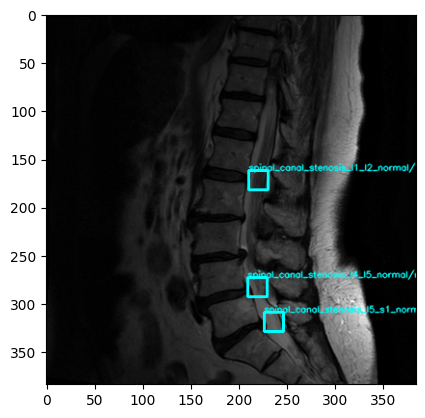

In [ ]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)
fontFace = cv2.FONT_HERSHEY_SIMPLEX

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [44]:
# ls data_fold0/labels/val

In [45]:
# os.path.join(_ANN_DIR, name+'.txt')

In [46]:
# cat 'train_fold0/labels/404602713_1230697721_12.txt'

In [47]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-yjhl4g4h
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-yjhl4g4h
  Resolved https://github.com/ultralytics/ultralytics.git to commit 4453ddab93c390c11c9f8bb8d90a761a4cec3342
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [48]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: spinal_canal_stenosis_l1_l2_normal/mild
1: spinal_canal_stenosis_l1_l2_moderate
2: spinal_canal_stenosis_l1_l2_severe
3: spinal_canal_stenosis_l2_l3_normal/mild
4: spinal_canal_stenosis_l2_l3_moderate
5: spinal_canal_stenosis_l2_l3_severe
6: spinal_canal_stenosis_l3_l4_normal/mild
7: spinal_canal_stenosis_l3_l4_moderate
8: spinal_canal_stenosis_l3_l4_severe
9: spinal_canal_stenosis_l4_l5_normal/mild
10: spinal_canal_stenosis_l4_l5_moderate
11: spinal_canal_stenosis_l4_l5_severe
12: spinal_canal_stenosis_l5_s1_normal/mild
13: spinal_canal_stenosis_l5_s1_moderate
14: spinal_canal_stenosis_l5_s1_severe


In [49]:
ls

data_fold0/  spine_detection/  state.db  yolo11n.pt  yolo_scs.yaml


In [50]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: spinal_canal_stenosis_l1_l2_normal/mild
    1: spinal_canal_stenosis_l1_l2_moderate
    2: spinal_canal_stenosis_l1_l2_severe
    3: spinal_canal_stenosis_l2_l3_normal/mild
    4: spinal_canal_stenosis_l2_l3_moderate
    5: spinal_canal_stenosis_l2_l3_severe
    6: spinal_canal_stenosis_l3_l4_normal/mild
    7: spinal_canal_stenosis_l3_l4_moderate
    8: spinal_canal_stenosis_l3_l4_severe
    9: spinal_canal_stenosis_l4_l5_normal/mild
    10: spinal_canal_stenosis_l4_l5_moderate
    11: spinal_canal_stenosis_l4_l5_severe
    12: spinal_canal_stenosis_l5_s1_normal/mild
    13: spinal_canal_stenosis_l5_s1_moderate
    14: spinal_canal_stenosis_l5_s1_severe
  

Overwriting yolo_scs.yaml


In [ ]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [51]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO('/kaggle/input/yolov11x/other/default/1/yolo11x.pt')
            
config = {
    'data': "/kaggle/working/yolo_scs.yaml",
    'imgsz': 384,
    'batch': 16,
    'epochs': 100,
    'patience': 15,
    'device': '0',
    'workers': 8,
    'project': 'spine_detection',
    'name': 'Canal_Stenosis_yolo',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'verbose': True,
    'seed': 42,
    'deterministic': True,
    'dropout': 0.2,
    'lr0': 0.001,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 10,
    'warmup_momentum': 0.8,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'close_mosaic': 10,
    'amp': True,
}

results = model.train(**config)

Ultralytics 8.3.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/yolov11x/other/default/1/yolo11x.pt, data=/kaggle/working/yolo_scs.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=384, save=True, save_period=-1, cache=False, device=0, workers=8, project=spine_detection, name=Spinal_Canal_Stenosis_yolo, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

train: Scanning /kaggle/working/data_fold0/labels/train.cache... 2013 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2013/2013 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val.cache... 509 images, 0 backgrounds, 0 corrupt: 100%|██████████| 509/509 [00:00<?, ?it/s]


Plotting labels to spine_detection/Spinal_Canal_Stenosis_yolo/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to spine_detection/Spinal_Canal_Stenosis_yolo
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.81G      2.576      2.866      1.253         59        384: 100%|██████████| 126/126 [01:26<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]

                   all        509       1950       0.35      0.325       0.23     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.67G      1.979      1.606     0.9946         77        384: 100%|██████████| 126/126 [01:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]

                   all        509       1950      0.472      0.394      0.327     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.83G      1.881      1.509     0.9795         69        384: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950      0.483       0.49      0.423      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.66G      1.884      1.508     0.9743         58        384: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]

                   all        509       1950      0.398      0.468      0.336      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.82G      1.887      1.512     0.9773         68        384: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.332      0.308      0.233     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.67G      1.841      1.442     0.9638         71        384: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950      0.463      0.557       0.47      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.83G      1.833      1.388     0.9608         58        384: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.493      0.491      0.444      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.67G      1.808       1.39     0.9578         55        384: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.382      0.504      0.405      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.67G      1.807      1.378      0.954         82        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.439      0.554       0.43      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.83G      1.801      1.368     0.9496         72        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.713      0.377       0.41      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.05G      1.783      1.343     0.9495         91        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.488       0.56      0.501      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.82G      1.812      1.328     0.9591         55        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.424      0.606      0.461      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.02G      1.737      1.287     0.9394         67        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.384      0.651      0.417      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.67G      1.753      1.282     0.9459         54        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950      0.544      0.542       0.46      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.86G      1.719      1.259     0.9397         63        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.553      0.601      0.545      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.66G      1.686      1.234     0.9307         76        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.468      0.671      0.534       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.88G      1.678      1.239      0.937        133        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.579      0.566      0.572      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.66G      1.701       1.24     0.9307         81        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.556      0.622      0.508      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.03G      1.708      1.204     0.9369        102        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950       0.62       0.55      0.516      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.83G      1.677      1.193     0.9321         70        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.615      0.588      0.552      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.87G      1.661      1.191     0.9289         87        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950       0.66      0.599      0.547      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.67G      1.676      1.194     0.9337         64        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.547       0.59      0.529      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.88G      1.684      1.189     0.9308         40        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]

                   all        509       1950      0.522       0.61      0.523       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.83G      1.643      1.173     0.9251         76        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.442      0.659      0.543      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.86G      1.637      1.162     0.9239         64        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.612       0.57      0.514      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.83G      1.624      1.141     0.9216         74        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.466      0.644      0.571      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.04G      1.617      1.147     0.9225         49        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.556      0.601       0.54      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.82G      1.628      1.144     0.9242         76        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.438      0.693      0.561      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.88G      1.622      1.153      0.925         57        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.582      0.565      0.511      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.83G      1.627      1.128      0.915         64        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.485      0.687      0.569      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.03G      1.613      1.113     0.9208         66        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]

                   all        509       1950      0.583      0.639      0.576      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.66G      1.612      1.116     0.9177         92        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.413      0.706      0.537      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.04G      1.607      1.118     0.9176         56        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.483      0.668      0.592      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.83G      1.608      1.104     0.9211         57        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950       0.58      0.588      0.536       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.04G      1.596      1.116     0.9202         71        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.473      0.702      0.574      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.66G      1.587      1.087     0.9129         81        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.493      0.656      0.527      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.87G      1.582      1.097     0.9113         47        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.455       0.72      0.539      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.83G      1.579      1.077     0.9191         58        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.522      0.655      0.564      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.04G      1.578      1.076      0.911         71        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950       0.49      0.684      0.569      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.67G      1.573      1.073     0.9122         87        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.518       0.67      0.562      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.04G      1.576      1.079     0.9179         97        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.464      0.684      0.533      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.66G      1.556      1.092     0.9105         60        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.608      0.611      0.597      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.87G      1.558      1.047     0.9115         80        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.476      0.681      0.565       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.66G      1.552      1.063     0.9094         55        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.477      0.691      0.537      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.87G      1.566       1.07     0.9116         62        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.463      0.657       0.54      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.82G      1.552      1.051     0.9087         69        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.522      0.669      0.555      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.04G      1.576      1.063     0.9144         48        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.472      0.706      0.562      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.82G      1.531      1.069     0.9055         73        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.503      0.676      0.532      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.03G      1.556      1.033     0.9093         75        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.485      0.676       0.58      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.67G      1.551       1.05      0.911         53        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.459      0.698      0.594      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.87G      1.551      1.035     0.9101         83        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.542      0.654      0.581      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.66G      1.543      1.026     0.9051         65        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.523      0.669      0.563      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.86G      1.549      1.029      0.907         64        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.512      0.735      0.581       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.66G      1.514      1.017     0.9024         95        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.518      0.695      0.571      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.87G       1.54      1.017      0.909         85        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.526      0.721      0.588      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.82G      1.533     0.9883     0.9091         52        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950      0.616      0.638       0.58      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.87G      1.513      1.014     0.9059         62        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950      0.496      0.672      0.549      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.82G      1.526      1.004     0.9097         58        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.538      0.656      0.595      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.03G      1.516      1.013     0.9062         72        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.516      0.646      0.574      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.66G      1.517     0.9946     0.9058         34        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.479      0.646      0.561       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.87G      1.515      1.011      0.909        100        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        509       1950      0.468       0.69      0.584      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.66G      1.502     0.9825     0.9007         77        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.498      0.683      0.564      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.88G      1.499       0.99     0.9028         65        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        509       1950      0.464      0.691      0.582      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.83G      1.501     0.9906     0.9027         59        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950      0.475      0.694      0.545      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.04G      1.493     0.9795     0.9005         48        384: 100%|██████████| 126/126 [01:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]

                   all        509       1950      0.474      0.708      0.573      0.285
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 50, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



65 epochs completed in 1.618 hours.
Optimizer stripped from spine_detection/Spinal_Canal_Stenosis_yolo/weights/last.pt, 114.4MB
Optimizer stripped from spine_detection/Spinal_Canal_Stenosis_yolo/weights/best.pt, 114.4MB

Validating spine_detection/Spinal_Canal_Stenosis_yolo/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x summary (fused): 464 layers, 56,844,349 parameters, 0 gradients, 194.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


                   all        509       1950      0.458      0.697      0.594      0.302
spinal_canal_stenosis_l1_l2_normal/mild        369        369      0.693      0.959      0.859      0.416
spinal_canal_stenosis_l1_l2_moderate          9          9      0.222      0.667      0.385      0.203
spinal_canal_stenosis_l1_l2_severe          2          2      0.158        0.5      0.606      0.159
spinal_canal_stenosis_l2_l3_normal/mild        350        350      0.717      0.949      0.843      0.414
spinal_canal_stenosis_l2_l3_moderate         27         27      0.222      0.333      0.298      0.176
spinal_canal_stenosis_l2_l3_severe          8          8      0.328      0.625      0.407      0.228
spinal_canal_stenosis_l3_l4_normal/mild        325        325      0.722      0.966      0.915      0.466
spinal_canal_stenosis_l3_l4_moderate         43         43      0.293       0.55       0.37      0.194
spinal_canal_stenosis_l3_l4_severe         27         27      0.528      0.741    

In [54]:
# Initialize YOLO Model
model = YOLO(glob.glob("/kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/weights/best.pt")[0])
out = model.predict([path], save=True, conf=0.2)



0: 384x352 1 spinal_canal_stenosis_l1_l2_normal/mild, 1 spinal_canal_stenosis_l2_l3_normal/mild, 1 spinal_canal_stenosis_l3_l4_severe, 1 spinal_canal_stenosis_l4_l5_severe, 1 spinal_canal_stenosis_l5_s1_normal/mild, 119.8ms
Speed: 1.6ms preprocess, 119.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 352)
Results saved to runs/detect/predict


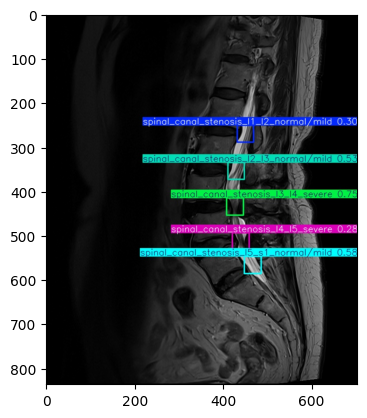

In [55]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)

In [61]:
!zip -r /kaggle/working/Canal_Stenosis_yolo.zip /kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo

updating: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/ (stored 0%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/weights/ (stored 0%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/weights/last.pt (deflated 8%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/weights/best.pt (deflated 8%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/events.out.tfevents.1731586706.84942577b8d6.34.0 (deflated 95%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/labels_correlogram.jpg (deflated 61%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/PR_curve.png (deflated 9%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/confusion_matrix_normalized.png (deflated 14%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/args.yaml (deflated 52%)
  adding: kaggle/working/spine_detection/Spinal_Canal_Stenosis_yolo/confusion_matrix.png (def